# Lista 10 - Regressão Múltipla

## Introdução

In [1]:
# -*- coding: utf8

from scipy import stats as ss

import matplotlib.pyplot as plt
from numpy.testing import assert_equal, assert_array_equal, assert_array_almost_equal
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

/var/folders/q8/9d5d2vtj4832w_98dq64xxr00000gn/T/ipykernel_99663/156476233.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

Continuando da aula passada, vamos agora focar em casos mais específicos de regressão. Nesta aula, vamos estender a ideia de mínimos quadrados e de regressão linear para modelos mais complexos. Para tal, vamos continuar nosso foco nos dados de preços de apartamentos em BH.

## Dados

Observe como temos 4 possíveis preditores de preço:
1. Área
1. Quartos
1. Suítes
1. Vagas

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/aptosBH.txt', index_col=0)
df.head()

,area,quartos,suites,vagas,preco
ID,,,,,
353534.0,110.00,3.0,1.0,2.0,880000.0
366113.0,101.89,3.0,1.0,4.0,900000.0
186728.0,191.00,3.0,1.0,3.0,920000.0
366115.0,101.89,3.0,1.0,4.0,950000.0
353022.0,280.61,3.0,1.0,4.0,1000000.0


Cada preditor é correlacionado com o preço de alguma forma. No pairplot abaixo, observe a última coluna, onde cada linha corresponde a um preditor.

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


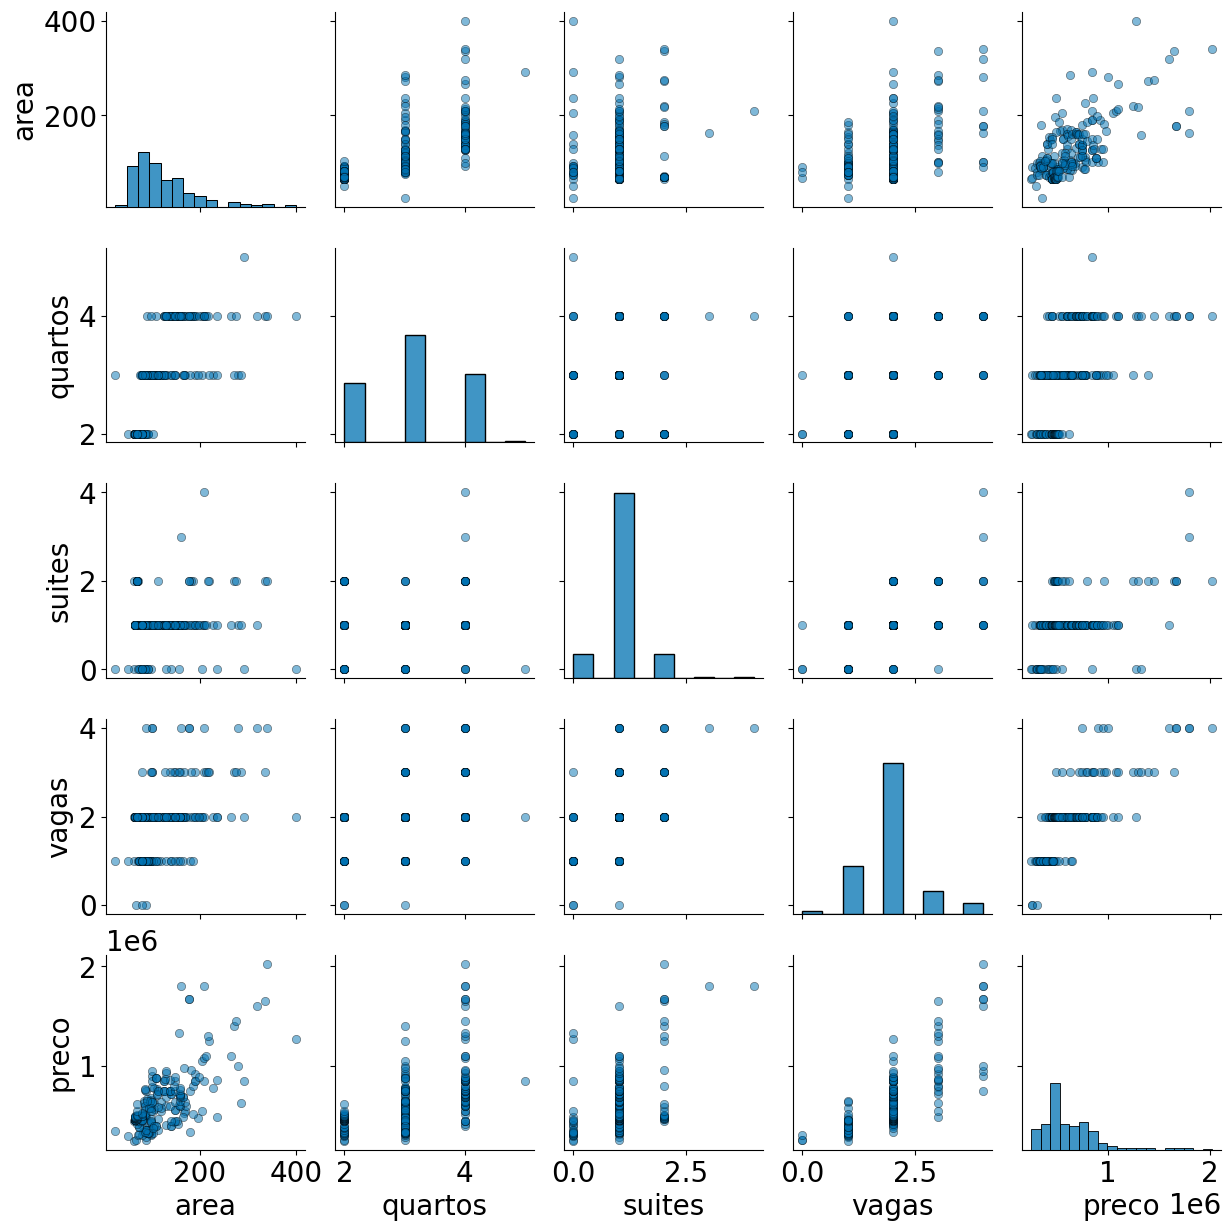

In [5]:
sns.pairplot(df, diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})

## Regressão Múltipla

Para realizar uma regressão múltipla, vamos representar nossos dados na forma matricial. Sendo `n` o número de linhas nos nossos dados (observações) e `f` o número de colunas (features/atríbutos). Os dados podem ser vistos como a matriz abaixo:

$$
\mathbf{X} = \begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix} =\begin{pmatrix}1&x_{11}&\cdots &x_{1f}\\1&x_{21}&\cdots &x_{2f}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{nf}\end{pmatrix}
$$

Observe como a primeira coluna é toda `1`. A mesma vai capturar o fator constante, intercepto, da regressão linear. O nosso modelo é capturado pela equação abaixo:

$$y_i = \theta_0 x_{i0} + \theta_1 x_{i1}^{1} + \theta_2 x_{i2}^{2} + \cdots + \theta_f x_{if}^{f} + \epsilon_i$$

Aqui, $x_{i0} = 1$ sempre (por isso usamos uma coluna de 1s). Dessa forma, obtemos a equação:

$$y_i = \theta_0 + \theta_1 x_{i1}^{1} + \theta_2 x_{i2}^{2} + \cdots + \theta_f x_{if}^{f} + \epsilon_i$$

Vamos organizar uma matriz de fatores explanatórios X usando pandas.

In [6]:
y = df['preco']
X = df[['area', 'quartos', 'suites', 'vagas']]
X['intercepto'] = 1
X = X[['intercepto', 'area', 'quartos', 'suites', 'vagas']]
X.head()

,intercepto,area,quartos,suites,vagas
ID,,,,,
353534.0,1,110.00,3.0,1.0,2.0
366113.0,1,101.89,3.0,1.0,4.0
186728.0,1,191.00,3.0,1.0,3.0
366115.0,1,101.89,3.0,1.0,4.0
353022.0,1,280.61,3.0,1.0,4.0


Temos 216 observações.

In [7]:
y.shape

(216,)

5 atributos, onde um deles é o intercepto.

In [8]:
X.shape

(216, 5)

X.values retorna a matriz.

In [9]:
X = X.values
y = y.values # pegar a matrix
X

array([[  1.  , 110.  ,   3.  ,   1.  ,   2.  ],
       [  1.  , 101.89,   3.  ,   1.  ,   4.  ],
       [  1.  , 191.  ,   3.  ,   1.  ,   3.  ],
       ...,
       [  1.  ,  70.  ,   2.  ,   2.  ,   2.  ],
       [  1.  ,  70.  ,   2.  ,   2.  ,   2.  ],
       [  1.  , 115.  ,   3.  ,   1.  ,   2.  ]])

## Modelo

Sendo $\mathbf{y}$ a nossa resposta. Na forma matricial o nosso modelo tem a seguinte forma:


$$\mathbf {y} =\mathbf{X}{\boldsymbol {\theta }}+{\boldsymbol {\varepsilon }} $$

Cada observação $y_i$ vai ser capturada pelo modelo linear $y_i = \theta_0 + \theta_1 x_{i1}^{1} + \theta_2 x_{i2}^{2} + \cdots + \theta_f x_{if}^{f} + \epsilon_i$. Basta pensar em operações de matrizes e vetores como somatórios! Cada linha de $\mathbf{X}$ multiplica o vetor de parâmetros $\theta$.

## Soma dos erros quadrados

A função de perda na forma matricial é:

$$L({\boldsymbol {\theta }}) = ||\mathbf{y} - \mathbf{X} {\boldsymbol {\theta }}||^2_2$$

Essa função é obtida através do quadrado da norma de Frobenius (com p=2), cuja fórmula é dada por:

$$||A||_p = (\sum_i \sum_j |a_{i,j}|^p)^{\frac{1}{p}}$$

## Jacobiana

Quando temos várias derivadas de equações na forma matricial, estamos computando a Jacobiana J (vetor de derivadas). Cada elemento do vetor J é uma derivada:

$$J(\theta) = [\frac{dL}{d\theta_0}, \frac{dL}{d\theta_1}, ..., \frac{dL}{d\theta_f}]$$


Um fator bastante interessante deste modelo é que todas as derivadas (para cada $\theta_i$) têm a mesma forma. Como temos uma soma de fatores lineares, cada $\theta_i$ vai ter o mesmo formato. Assim:

$$\frac{dL}{d\theta_j} = -2n^{-1} \sum_{i=1}^{n} (y_i - \sum_{j=0} \theta_j x_{ij}) x_{ij}$$

$$\frac{dL}{d\theta_j} = -2n^{-1} \sum_{i=1}^{n} \epsilon_i x_{ij}$$

A função abaixo computa tal derivada explorando o conceito de vetorização.

In [10]:
def derivadas_regressao_media_old(theta, X, y):
    return -2 * ((y - X @ theta) * X.T).mean(axis=1)

In [11]:
def derivadas_regressao(theta, X, y):
    return -2 * ((y - X @ theta) @ X)

## Versão nova da função da média

In [12]:
def derivadas_regressao_media(theta, X, y):
    return -2 * ((y - X @ theta) @ X) / len(y)

## Gradiente Descendente

Após definir o modelo, a função de erro e a Jacobiana para a Regressão Múltipla, podemos calcular o gradiente descendente!

In [13]:
# def gd(theta, d_fun, X, y, lambda_=0.0001, tol=0.00001, max_iter=10000):
#   theta = theta.copy()
#   #print('Iter {}; theta = '.format(0), theta)
#   old_err_sq = np.inf
#   i = 0
#   while True:
#     # Computar as derivadas
#     grad = d_fun(theta, X, y)
#     # Atualizar
#     theta_novo = theta - lambda_ * grad
    
#     # Parar quando o erro convergir
#     err_sq = ((X.dot(theta) - y) ** 2).mean()
#     if np.abs(old_err_sq - err_sq) <= tol:
#       break
#     theta = theta_novo
#     old_err_sq = err_sq
#     #print('Iter {}; theta = '.format(i+1), theta)
#     i += 1
#     if i == max_iter:
#       break
#   return theta

## Gradiente Descendente Estocástico

O gradiente descendente estocástico também funciona! Entretanto, temos que acertar a taxa de aprendizado.
Um dos problemas do uso recorrente do gradiente descendente estocástico é que não sabemos ainda como acertar nossa taxa. Para tal, geralmente fazemos uso de treino/validação/teste (assunto das próximas aulas).

In [14]:
# def sgd(theta, d_fun, X, y, lambda_=0.001, tol=0.01, max_iter=10000):
#   theta = theta.copy()
#   #print('Iter {}; alpha, beta = '.format(0), theta)
#   old_err_sq = np.inf
#   for i in range(max_iter):
#     # Escolhe ponto aleatório
#     r = np.random.randint(len(y))
#     X_r, y_r = X[r], y[r]
#     X_r = X_r.reshape(1, len(X_r)) # transforma o vetor linha em matriz
            
#     # Deriva e atualiza
#     grad = d_fun(theta, X_r, y_r)
#     theta_novo = theta - lambda_ * grad
    
#     #Calcula o erro
#     err_sq = ((X.dot(theta) - y) ** 2).mean()
    
#     theta = theta_novo
#     if err_sq < tol:
#       break
    
#       #print('Iter {}; alpha, beta = '.format(i+1), theta)

#   return theta

## Normalização dos Dados

A normalização dos dados pode ser útil para ajudar o gradiente. O algoritmo funciona sem tal passo, porém é mais chato definir uma taxa de aprendizado quando não temos isto e, além disso, a convergência é mais lenta.

Quando as features aparecem com ordens de grandeza muito diferentes (ex: idade entre 0 a 100 e renda mensal entre  800 e 100.000 reais) a função de custo é distorcida, tornando o ponto mínimo difícil de alcançar. Sendo assim, um truque importante é garantir que todos as features estejam em uma escala similar. 

Abaixo normalizamos as features dos dados de preços de apartamentos em BH e, em seguida, calculamos o gradiente descendente e o gradiente descendente estocástico.

In [15]:
# df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/aptosBH.txt', index_col=0)
# z_df = (df-df.mean())/df.std()

# y = z_df['preco']
# X = z_df[['area', 'quartos', 'suites', 'vagas']]
# X['intercepto'] = 1

# X = X.values
# y = y.values

# theta = np.ones(5)
# theta = gd(theta, derivadas_regressao, X, y)

In [16]:
# print("theta = ", theta)

In [17]:
# print(X[0:4])

In [18]:
# df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/aptosBH.txt', index_col=0)
# z_df = (df-df.mean())/df.std()

# y = z_df['preco']
# X = z_df[['area', 'quartos', 'suites', 'vagas']]
# X['intercepto'] = 1

# X = X.values
# y = y.values

# theta = np.ones(5)
# theta = sgd(theta, derivadas_regressao, X, y, lambda_=0.002)

In [19]:
# print("theta = ", theta)

Observe como os resultados batem com o scikit learn.

In [20]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression(fit_intercept=True)
# model.fit(X, y)

In [21]:
# model.coef_

In [22]:
# model.intercept_

## Erros e Validação

Ainda podemos usar o R-quadrado para avaliar a qualidade de uma regressão linear múltipla. A interpretação permanece a mesma: quanto da variância dos dados é capturada pelo modelo.

* Ainda considerando o exemplo da predição do preço de apartamentos em BH, calcule o valor do R-quadrado da regressão com os dados normalizados. Faça o mesmo usando os dados não normalizados.

In [23]:
# def erro(y, X, theta):
#   return y - X@theta

# def multiple_r_squared(X, y, theta):
#   sse = sum(erro(y, X, theta)**2)
#   sst = sum((y - np.mean(y))**2)
#   return 1.0 - sse / sst


# df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/aptosBH.txt', index_col=0)

# y = df['preco']
# X = df[['area', 'quartos', 'suites', 'vagas']]
# X['intercepto'] = 1

# X = X.values
# y = y.values

# model = LinearRegression(fit_intercept=False)
# model.fit(X, y)
# print(model.coef_)
# print("R2 sem normalizacao = ", model.score(X, y))


# df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/aptosBH.txt', index_col=0)
# z_df=(df-df.mean())/df.std()

# y = z_df['preco']
# X = z_df[['area', 'quartos', 'suites', 'vagas']]
# X['intercepto'] = 1

# X = X.values
# y = y.values

# model = LinearRegression(fit_intercept=False)
# model.fit(X, y)
# print(model.coef_)
# print("R2 com normalizacao = ", model.score(X, y))

## Bootstrap para entender a importância de fatores

Podemos aplicar um bootstrap para entender a importância dos fatores. Nós repetidamente tomamos um `bootstrap_regression` dos nossos dados e estimamos o vetor `\Theta` com base nessa amostra. Se o coeficiente correspondente a uma das variáveis independentes não variar muito entre as amostras, podemos ter certeza de que nossa estimativa é relativamente segura. Se o coeficiente variar muito entre as amostras, não podemos ficar confiantes em nossa estimativa. Caso o intervalo capture o zero, o fator não importa do ponto de vista estatístico. Vamos fazer uso de scikit learn.

Vamos ver exemplos nos dados dos apartamentos.

In [24]:
# def bootstrap_regression(X, y, n=10000, size=None):
#   if size is None:
#     size = len(df)
      
#   T = np.zeros(shape=(n, X.shape[1]))
#   for i in range(n):
#     # Gera amostras com reposição
#     idx = np.random.choice(len(y), len(y))
#     Xb = X[idx]
#     yb = y[idx]
    
#     # Fit usando sklearn
#     model = LinearRegression(fit_intercept=True)
#     model.fit(Xb, yb)
    
#     T[i] = model.coef_
#   return T

A seguir, não usamos o scikit learn e eliminamos duplicatas da amostra:

In [25]:
# def bootstrap_regression_gd(X, y, n=10000, size=None):
#   if size is None:
#     size = len(df)
      
#   T = np.zeros(shape=(n, X.shape[1]))
#   for i in range(n):
#     if i%400 == 0:
#       print("bootstrap iter ", i)
#     # Gera amostras com reposição e remove duplicatas
#     idx = list(np.random.choice(len(y), len(y)))
#     Xb = X[idx]
#     yb = y[idx]
    
#     # Fit usando gd
#     theta = np.ones(X.shape[1])
#     theta = gd(theta, derivadas_regressao, Xb, yb)
    
#     T[i] = theta
#   return T

In [26]:
# y = z_df['preco'].values
# names = ['area', 'quartos', 'suites', 'vagas']
# X = z_df[names]
# X['intercepto'] = 1
# X = X.values

# T = bootstrap_regression_gd(X, y)
# names = ['area', 'quartos', 'suites', 'vagas', 'intercepto']

# for col in range(T.shape[1]):
#   fig = plt.figure()
#   plt.hist(T[:, col], edgecolor='k')
#   plt.title('{} - 95% CI Bootstrap: ({:.2f}, {:.2f})'.format(names[col],
#                                                              np.percentile(T[:, col], 2.5),
#                                                              np.percentile(T[:, col], 97.5)))
#   plt.xlabel(r'$\theta_i$')
#   plt.ylabel('# Boot Amostras')
#   despine()
#   plt.show()

##  Exercícios - Outros datasets:

### Carros

Utilizando a base de dados carros, ``hybrid.csv``, vamos fazer um gradiente descendente para uma regressão linear com múltiplas variáveis. As colunas são definidas da seguinte forma:

veículo (vehicle): modelo do carro

ano (year): ano de fabricação

msrp: preço de varejo em dólar sugerido pelo fabricante em 2013.

aceleração (acceleration): taxa de aceleração em km por hora por segundo

mpg: economia de combustível em milhas por galão

classe (class): a classe do modelo.

Nosso objetivo será estimar o valor de preço sugerido dos carros a partir dos demais atributos (exluindo o nome do veículo e a classe).
Portanto, teremos a regressão definida pela fórmula:

$$ Y = X\Theta + \epsilon $$

onde, Y corresponde à coluna ``msrp`` dos dados, e X corresponde às colunas ``year,acceleration,mpg``.

Observe a forma dos dados e a correlação entre as variáveis:

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/hybrid.csv')
df.head()

,vehicle,year,msrp,acceleration,mpg,class
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact
1,Tino,2000,35354.97,8.20,54.10,Compact
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact
3,Insight,2000,18936.41,9.52,53.00,Two Seater
4,Civic (1st Gen),2001,25833.38,7.04,47.04,Compact


/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


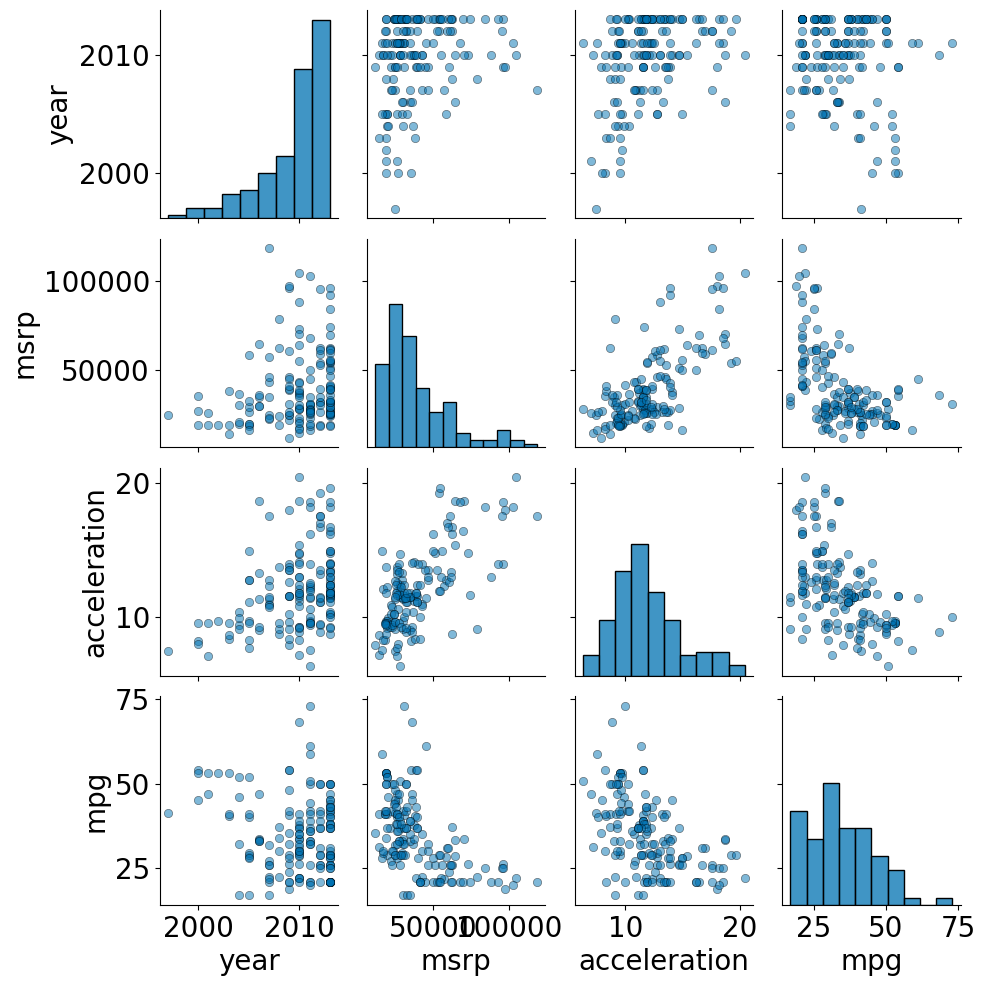

In [28]:
import seaborn as sns
sns.pairplot(df, diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})

**Exercício 1:** Selecione apenas as colunas que serão utilizadas e normalize os dados para que o gradiente descendente rode sem problemas.

In [29]:
# SELECIONE AS COLUNAS
y = df['msrp']
X = df[['year', 'acceleration', 'mpg']]

# NORMALIZE OS DADOS
X = (X - X.mean()) / X.std(ddof=1)
y = (y - y.mean()) / y.std(ddof=1)
# ACRESCENTE INTERCEPTO
intercept = np.ones(y.size)
X.insert(0, 'intercepto', intercept, True)
# EXTRAIA MATRIZES COM .VALUES
X = X.values
y = y.values
print(X,y)

[[ 1.         -3.67677448 -1.52998404  0.5889757 ]
 [ 1.         -2.80953939 -1.27830259  1.75917155]
 [ 1.         -2.80953939 -1.35652791  0.95078859]
 [ 1.         -2.80953939 -0.8293573   1.65892112]
 [ 1.         -2.52046103 -1.67283027  1.11574611]
 [ 1.         -2.52046103 -0.8293573   1.65892112]
 [ 1.         -2.23138266 -0.76473638  1.65892112]
 [ 1.         -1.9423043  -1.23408828  0.5160663 ]
 [ 1.         -1.9423043  -0.8293573   1.65892112]
 [ 1.         -1.9423043  -1.13545636  0.56528015]
 [ 1.         -1.65322594 -0.55726924 -0.25586195]
 [ 1.         -1.65322594 -0.88717601  1.56778438]
 [ 1.         -1.65322594 -0.70011547  1.02096389]
 [ 1.         -1.65322594 -0.97560463 -1.62200181]
 [ 1.         -1.36414757  0.27259933 -0.59853613]
 [ 1.         -1.36414757 -1.47216533  0.47323203]
 [ 1.         -1.36414757  0.27259933 -0.49190613]
 [ 1.         -1.36414757 -0.76473638  1.56778438]
 [ 1.         -1.36414757 -1.25789599  0.56528015]
 [ 1.         -1.36414757 -0.82

**Exercício 2:** Implemente a função de gradiente dos parâmetros da regressão, retornando um array com os valores dos gradientes para cada parâmetro.

In [30]:
def gradients(theta, X, y):
  # YOUR CODE HERE
  # x : matriz nxm
  # y : array nx1
  # theta : array mx1
  gradients = -2 * ((y - X @ theta) @ X) / len(y)
  return gradients

* Implemente a função de gradiente descendente para os parâmetros da regressão, retornando um array com os valores de alpha e os valores de beta para cada coluna. Você deve usar a função `gradients` definida anteriormente.

In [31]:
def descent(theta0, X, y, learning_rate=0.005, tolerance=0.0000001):
  # YOUR CODE HERE
  old_err_sq = np.inf
  i = 0
  niters = 10000
  for i in range(niters):
    grad = gradients(theta0, X, y)
    theta = theta0 - learning_rate * grad 
    err_sq = ((X.dot(theta) - y) ** 2).mean()
    if np.abs(old_err_sq - err_sq) <= tolerance:
      break
    theta0 = theta
    old_err_sq = err_sq

  return theta

In [32]:
_teste_param0 = np.array([ 1000, 1, 1, 1 ])
theta = descent(_teste_param0, X, y)
assert_array_almost_equal(theta, np.array([ 0.00201339, -0.04349112,  0.59055261, -0.23979036]))

**Exercício 3:** Agora vamos tentar avaliar o modelo de regressão linear obtido com o gradiente descendente. Para isso, implemente a função que calcula o R-quadrado. 

Lembre-se que, para calcular o R-quadrado, você precisa do valor da soma total dos quadrados e da soma dos erros quadrados. Os parâmetros de entrada de cada função são dados.

In [33]:
def sst(y):
  # YOUR CODE HERE
  sst = ((y - y.mean())**2).sum()
  return sst

def predict(X, theta):
  # YOUR CODE HERE
  y_pred = X.dot(theta)
  return y_pred

def sse(X, y, theta):
  # YOUR CODE HERE
  sse = ((y - X.dot(theta))**2).sum()
  return sse

def rsquared(X, y, theta):
  # YOUR CODE HERE
  return 1 - sse(X, y, theta) / sst(y)

In [34]:
rs = rsquared(X, y, theta)
assert_equal(rs, 0.5288887684860548)

Se observarmos os dados pelos gráficos que mostram as correlações entre as variáveis, podemos perceber que nem todos possuem uma relação linear. Vamos tentar transformar os dados de um dos atributos dos carros, para que uma regressão linear possa ser aplicada com melhores resultados.

**Exercício 4:** Para isso, tire o logaritmo da variável ```mpg``` e, em seguida, z-normalize os dados (todos as variáveis em X).

In [35]:
y = df['msrp']
X = df[['year','acceleration','mpg']]

# TIRE O LOG DA VARIAVEL MPG
X['mpg'] = np.log(X['mpg'])

# Z-NORMALIZE OS DADOS
normalized_x = (X - X.mean()) / X.std()
normalized_y = (y - y.mean()) / y.std()

# ADICIONE O INTERCEPTO
X['intercepto'] = 1

# DEFINA X e Y UTILIZANDO .VALUES
X = X[['intercepto', 'year', 'acceleration', 'mpg']].values
y = y.values

/var/folders/q8/9d5d2vtj4832w_98dq64xxr00000gn/T/ipykernel_99663/4005682991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['mpg'] = np.log(X['mpg'])
/var/folders/q8/9d5d2vtj4832w_98dq64xxr00000gn/T/ipykernel_99663/4005682991.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercepto'] = 1


* Rode novamente o código do gradiente descendente e verifique se o R-quadrado da regressão melhorou ou piorou após a transformação dos dados.

In [36]:
_teste_param0 = np.array([ 1000, 1, 1, 1 ])
theta = descent(_teste_param0, X, y)

assert_equal(rsquared(X,y,theta), 0.5543728866213389)

/var/folders/q8/9d5d2vtj4832w_98dq64xxr00000gn/T/ipykernel_99663/3577983559.py:9: RuntimeWarning: overflow encountered in square
  err_sq = ((X.dot(theta) - y) ** 2).mean()
/var/folders/q8/9d5d2vtj4832w_98dq64xxr00000gn/T/ipykernel_99663/3577983559.py:10: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(old_err_sq - err_sq) <= tolerance:
/var/folders/q8/9d5d2vtj4832w_98dq64xxr00000gn/T/ipykernel_99663/3122734375.py:6: RuntimeWarning: overflow encountered in matmul
  gradients = -2 * ((y - X @ theta) @ X) / len(y)
/var/folders/q8/9d5d2vtj4832w_98dq64xxr00000gn/T/ipykernel_99663/3577983559.py:8: RuntimeWarning: invalid value encountered in subtract
  theta = theta0 - learning_rate * grad


AssertionError: 
Items are not equal:
 ACTUAL: nan
 DESIRED: 0.5543728866213389

### ATENÇÃO

Os próximos dois exercícios não possuem correção automática, porém são de vital importância. Ambos os datasets utilizados nos exercícios a seguir são datasets com grande número de variáveis, o que se aproxima de problemas reais. Como a realização de testes com os valores é dificultada devido ao alto número de variáveis, optou-se pela não correção automática.

Tente encontrar o modelo que melhor se ajusta aos dados, com maior valor de $R²$. Tente também compreender a interpretação dos coeficientes para cada variável explicativa. Em caso de dúvidas, acione o monitor da disciplina.

### Dataset Reações Químicas - SEM CORREÇÃO AUTOMÁTICA

Um cientista maluco misturou quantidades (em milímetros cúbicos) aleatórias de diversos reagentes e conseguiu gerar uma determinada quantidade (em milímetros cúbicos) de um produto químico, que embora não sirva para nada, não é tóxico e é muito bonito. O problema é que o cientista não sabe quais reagentes estão, de fato, reagindo e gerando o tal produto. Mais importante, ele não sabe a quantidade que ele tem que colocar de cada reagente para gerar uma dada quantidade do produto. Para descobrir, ele misturou quantidades aleatórias de cada reagente 1000 vezes e anotou a quantidade do produto que foi gerada em cada um desses experimentos. Para encontrar a fórmula mágica tão desejada, ele pediu a sua ajuda. Os experimentos estão descritos nas linhas do arquivo. A quantidade gerada do produto para cada experimento está descrita na linha "q_produto". 

E aí? Será que regressão linear múltipla resolve? O professor sabe que resolve, e tem um modelo com $R^2$ superior a $0.99$. 

* Encontre esse modelo e mostre os coeficientes, a qualidade do ajuste, e os fatores significativos. Você pode utilizar as funções definidas anteriormente, ou utilizar a biblioteca sklearn.

In [37]:
df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/chemical_reaction.csv')
df.head()

,q_produto,q_reagente_116,q_reagente_158,q_reagente_18,q_reagente_199,q_reagente_219,q_reagente_226,q_reagente_263,q_reagente_273,q_reagente_278,...,q_reagente_519,q_reagente_527,q_reagente_575,q_reagente_6,q_reagente_607,q_reagente_652,q_reagente_804,q_reagente_875,q_reagente_881,q_reagente_964
0,3428.673522,92.137035,14.079712,28.643950,25.372276,18.289846,17.076072,2.901502,14.742738,99.545861,...,72.339598,35.637056,24.995370,49.289794,27.811497,25.764701,402.293234,22.804591,25.716139,2.691570
1,3948.229590,56.839770,13.803082,42.557560,25.184082,21.905475,17.712958,5.556623,3.384606,155.477082,...,71.836274,9.700495,27.524265,66.765039,34.779973,18.437969,116.751047,0.000000,19.688559,4.997487
2,4331.650198,77.566164,14.406301,29.468819,22.124179,19.858404,17.515865,4.053366,10.054049,143.705008,...,63.652580,19.945071,26.505182,39.582032,26.960548,15.038279,229.536187,11.460976,26.045952,2.409985
3,4530.153671,100.463237,18.494555,23.825064,16.914770,22.210331,17.416410,5.780492,17.421985,181.786609,...,49.720042,25.430917,27.532888,45.951732,32.820727,20.077703,289.931261,25.243309,19.865627,4.349159
4,4699.087741,82.795664,17.347322,24.402419,24.935485,22.400284,16.741933,5.919984,11.736824,161.379815,...,71.171403,22.102092,27.705269,43.655474,30.476209,36.563123,253.283373,24.863983,20.994606,3.573342


In [ ]:
# def derivadas_regressao(theta, X, y):
#     return -2 * ((y - X @ theta) @ X)


# def gd(theta, d_fun, X, y, lambda_=0.0001, tol=0.000001, max_iter=100000):
#     theta = theta.copy()
#     #print('Iter {}; theta = '.format(0), theta)
#     old_err_sq = np.inf
#     i = 0
#     while True:
#         # Computar as derivadas
#         grad = d_fun(theta, X, y)
#         # Atualizar
#         theta_novo = theta - lambda_ * grad
        
#         # Parar quando o erro convergir
#         err_sq = ((X.dot(theta) - y) ** 2).mean()
#         if np.abs(old_err_sq - err_sq) <= tol:
#             break
#         theta = theta_novo
#         old_err_sq = err_sq
#         print('Iter {}; theta = '.format(i+1), theta)
#         i += 1
#         if i == max_iter:
#             break
#     return theta

# def multiple_r_squared(X, y, theta):
#     sse = sum(erro(y, X, theta)**2)
#     sst = sum((y - np.mean(y))**2)
#     return 1.0 - sse / sst

In [ ]:
# df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/chemical_reaction.csv', index_col=0)
# z_df=(df-df.mean())/df.std()

# X = z_df.iloc[:, 1:]
# y = z_df.iloc[:, 0]
# X['intercepto'] = 1

# X = X.values
# y = y.values

# theta = np.zeros(X.shape[1])

# theta = gd(theta, derivadas_regressao, X, y)
# rm2 = multiple_r_squared(X, y, theta)

In [ ]:
# theta

In [ ]:
# rm2

In [ ]:
# def bootstrap_regression_gd(X, y, n=100, size=None):
#     if size is None:
#         size = len(df)
        
#     T = np.zeros(shape=(n, X.shape[1]))
#     for i in range(n):
#         if i%500 == 0:
#             print("bootstrap iter ", i)
#         # Gera amostras com reposição e remove duplicatas
#         idx = list(set(np.random.choice(len(y), len(y))))
#         Xb = X[idx]
#         yb = y[idx]
        
#         # Fit usando gd
#         theta = np.ones(X.shape[1])
#         theta = gd(theta, derivadas_regressao, Xb, yb, lambda_=0.0001, tol=0.0001, max_iter=1000)
        
#         T[i] = theta
#     return T

In [ ]:
# T = bootstrap_regression_gd(X, y)

In [ ]:
# for col in range(T.shape[1]):
#     fig = plt.figure()
#     plt.hist(T[:, col], edgecolor='k')
#     plt.title('{} - 95% CI Bootstrap: ({:.2f}, {:.2f})'.format(col,
#                                                              np.percentile(T[:, col], 2.5),
#                                                              np.percentile(T[:, col], 97.5)))
#     plt.xlabel(r'$\theta_i$')
#     plt.ylabel('# Boot Amostras')
#     despine()
#     plt.show()

#### Usando o sklearn

In [43]:
from sklearn.linear_model import LinearRegression

df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/chemical_reaction.csv', index_col=0)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

lm = LinearRegression()
lm.fit(X, y)

print("Coeficientes: {}".format(lm.coef_))
print("Intercept: {}".format(lm.intercept_))
print("R^2: {}".format(lm.score(X, y)))

Coeficientes: [ 2.04202169e-16 -4.88498131e-15  3.21107761e-16 -4.40896403e-15
 -2.54798123e-14 -3.47288275e-15  3.10766459e+00  1.26907727e-15
  1.80520145e-15 -7.44125667e-17 -1.06712710e-15  3.03690994e-16
 -3.76021259e-15 -5.75059956e-17 -1.57683547e-16  7.97497001e-15
  1.74168222e-16 -5.05549800e-16 -2.23785391e-16  1.12454623e-17
 -5.43448183e-16  1.20943322e-15 -1.29882563e-16]
Intercept: 46.32155050809118
R^2: 1.0


In [44]:
y

array([ 92.13703468,  56.83977012,  77.56616388, 100.46323712,
        82.79566386, 117.9022195 , 107.38457194,  69.43865479,
        93.54059085,  99.97494871, 108.58684044,  58.47274896,
       113.66148885, 121.9059158 , 116.87929238, 109.05228455,
       115.37531778,  95.01520179, 112.25582794,  98.77388548,
        98.57273898,  91.34002507, 119.72656555, 114.53113377,
       130.21782114, 102.87543979,  65.50340882, 104.67023561,
        75.7432273 , 106.93870945, 115.34632567, 103.05710259,
       115.87306848,  85.77537159, 102.92583389, 113.46264633,
       112.3129444 ,  84.24588943,  79.06507699,  79.17464104,
       111.1530517 , 101.07512938, 102.65370434,  96.83129438,
        70.89704459,  77.64959038,  90.85717769,  56.7161594 ,
        86.14360123,  84.30742709,  90.35309587,  90.35338862,
       109.22270764, 114.66924569, 102.84580944,  79.8978951 ,
        97.35279942,  72.75312792, 103.37507322,  84.56688372,
       111.36922052, 120.30180158,  96.68629901, 104.39

In [45]:
import statsmodels.api as sm

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.368e+29
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:25:47   Log-Likelihood:                 27620.
No. Observations:                1000   AIC:                        -5.520e+04
Df Residuals:                     980   BIC:                        -5.510e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4045   5.17e-15   7.83e+13      0.0

### Dataset FIFA - SEM CORREÇÃO AUTOMÁTICA

O [FIFA](https://pt.wikipedia.org/wiki/FIFA_(s%C3%A9rie)) é um jogo eletrônico de futebol muito popular em que, parte da diversão, é poder jogar partidas envolvendo jogadores reais. Para simular um jogador real, o jogo descreve-os usando diversos atributos (como poder do chute, velocidade, etc) que, de alguma forma, resultado em sua habilidade como um todo (*overall*). 

* Neste exercício você deve encontrar um modelo linear que explique a habilidade *overall* dos jogadores do FIFA a partir das suas outras habilidades. Para isso, utilize o arquivo contendo as habilidades de 20 mil jogadores. Mostre os coeficientes, a qualidade do ajuste e os fatores significativos. 

**Dica:** pode haver mais de um modelo!

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/skills_and_overall_sample_20k.csv', index_col=0)
df.head()

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Free Kick Accuracy,Overall,Position,Position class,ID,VersionID
71672,37,51,57,62,49,44,35,57,60,69,65,67,58,68,82,72,68,67,68,74,63,56,55,48,57,65,64,14,14,6,11,14,44,62,CDM,Midfield,203979,203979001
195550,25,25,25,37,25,25,25,31,29,46,50,34,71,42,42,54,35,70,25,32,20,25,25,27,25,25,25,68,65,62,67,68,25,67,GK,Goalkeeper,164507,164507032
119189,56,33,53,69,30,55,46,66,72,73,67,74,58,71,74,56,70,74,35,72,68,69,68,67,56,60,60,12,6,7,14,10,29,64,CM,Midfield,183768,183768011
97807,37,11,65,54,12,27,18,37,51,63,71,62,58,58,41,77,72,74,17,63,61,24,47,27,56,65,57,6,9,8,9,8,19,62,CB,Defense,170027,170027010
177150,39,63,62,46,57,57,44,44,64,78,77,85,66,69,65,71,73,72,44,52,25,64,55,62,25,25,25,4,6,6,5,6,36,65,ST,Attack,190254,190254023


In [ ]:
from sklearn.linear_model import LinearRegression

X = df.iloc[:, 1:33].values
y = df.iloc[:, 33].values

lm = LinearRegression()
lm.fit(X, y)

print("Coeficientes: {}".format(lm.coef_))
print("Intercept: {}".format(lm.intercept_))
print("R^2: {}".format(lm.score(X, y)))

Coeficientes: [ 0.01084735  0.10576893  0.06986422 -0.00835185  0.00571818  0.00442602
  0.01561893  0.183403    0.03083597  0.04326414  0.00430891  0.24256125
 -0.00652148  0.03605648  0.01427776 -0.026015    0.0534794  -0.02479087
  0.00854711  0.01637681 -0.01793254  0.02066591  0.01385459  0.01055705
  0.01445376 -0.00963099  0.17505381  0.04758202 -0.01168633  0.07283677
  0.04387138  0.00858583]
Intercept: 11.85812704163773
R^2: 0.7092700713433605


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1522.
Date:                Wed, 28 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:13:25   Log-Likelihood:                -54957.
No. Observations:               20000   AIC:                         1.100e+05
Df Residuals:                   19967   BIC:                         1.102e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8581      0.333     35.567      0.0